In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os
import time
from sklearn.metrics import accuracy_score, f1_score
from keras.datasets import mnist, cifar10
from sklearn.model_selection import train_test_split 

# 1. Define model

In [3]:
class KNN:
    def fit(self, X, y, k=1):
        self.X = X
        self.y = y
        self.k = k
    
    def predict(self, Z):
        N, M = self.X.shape[0], Z.shape[0]
        y_pred = np.empty((M, 1))
        X2 = np.sum((self.X)*(self.X), 1)
        Z2 = np.sum(Z*Z, 1)
        res = Z2.reshape(-1, 1) + X2.reshape(1, -1) - 2*Z.dot(self.X.T)
        idx = np.argsort(res, axis=1)[:, :self.k]
        labels = self.y[idx]

        for i in range(M):
            bincount = np.bincount(labels[i])
            y_pred[i] = np.argmax(bincount)
        return y_pred

In [93]:
class MNB:
    def fit(self, X, y, alpha=1):
        N, self.d = X.shape
        self.n_classes = len(np.unique(y))

        N_ci = np.empty((self.n_classes, self.d))
        N_c = np.empty((self.n_classes, 1))
        self.lamb = np.empty((self.n_classes, self.d))
        self.p = np.empty((self.n_classes, 1))

        for c in range(self.n_classes):
            N_c[c] = np.sum(X[y==c])
            N_ci[c] = np.sum(X[y==c], axis=0)
            self.lamb[c] = (N_ci[c] + alpha) / (N_c[c] + self.d*alpha)
            self.p[c] = len(y[y==c]) / len(y)

        # print(self.lamb.shape)
    
    def predict(self, X):
        N = X.shape[0]
        y_pred = np.empty((N, self.n_classes))
        
        # for i in range(N):
        for c in range(self.n_classes):
            y_pred[:, c] = self.p[c] * np.prod(self.lamb[c] ** X, axis=1) #axis=1
        # print(self.lamb[1] ** X)

        # return y_pred
        # return y_pred / y_pred.sum(axis=1, keepdims=True)
        return np.argmax(y_pred, axis=1)

# 2. MNIST

In [418]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [419]:
X_train = X_train.reshape(-1, 784)
X_train = X_train.astype('float32')
X_test = X_test.reshape(-1, 784)
X_test = X_test.astype('float32')

# normalize
X_train /= 255
X_test /= 255
print('Train samples:', X_train.shape)
print('Test samples:', X_test.shape)

Train samples: (60000, 784)
Test samples: (10000, 784)


## Train, Evaluate

In [420]:
# Save train time each model
train_times = []
# save scores each model
accuracy_scores = []
f1_scores = []

In [421]:
knn = KNN()

start = time.time()
knn.fit(X_train, y_train, k=7)
y_pred = knn.predict(X_test)
tmp = time.time() - start
train_times.append(tmp)

acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='macro')
accuracy_scores.append(acc)
f1_scores.append(f1)

print('KNN:')
print('Huấn luyện và đánh giá xong sau {:.2f}s'.format(tmp))
print('Accuracy score: {:.3f} %'.format(acc * 100))
print('F1 score:       {:.3f} %'.format(f1 * 100))

KNN:
Huấn luyện và đánh giá xong sau 71.27s
Accuracy score: 96.940 %
F1 score:       96.938 %


In [422]:
mnb = MNB()

start = time.time()
mnb.fit(X_train, y_train, 0.5)
y_pred = mnb.predict(X_test)

acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='macro')
accuracy_scores.append(acc)
f1_scores.append(f1)

tmp = time.time() - start
train_times.append(tmp)

print('MNB:')
print('Huấn luyệnvvà đánh giá xong sau {:.2f}s'.format(tmp))
print('Accuracy score: {:.3f} %'.format(acc * 100))
print('F1 score:       {:.3f} %'.format(f1 * 100))

MNB:
Huấn luyệnvvà đánh giá xong sau 1.44s
Accuracy score: 70.900 %
F1 score:       71.797 %


## Visualize

In [423]:
models = np.array(['KNN', 'Multinomial NB'])

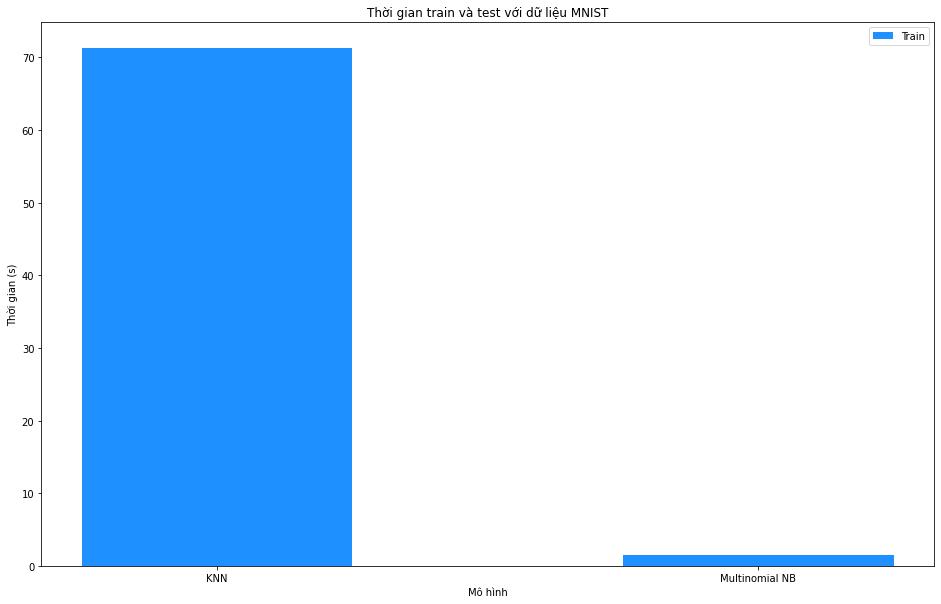

In [424]:
# Về thời gian
plt.figure(figsize=(16, 10))
plt.title('Thời gian train và test với dữ liệu MNIST')
plt.xlabel('Mô hình')
plt.ylabel('Thời gian (s)')
plt.bar(models, np.array(train_times), color='dodgerblue', width=0.5, label='Train')
plt.legend(loc='best')
plt.savefig('image/knn_mnb/mnist_time_comparision.png', facecolor='whitesmoke')
plt.show()

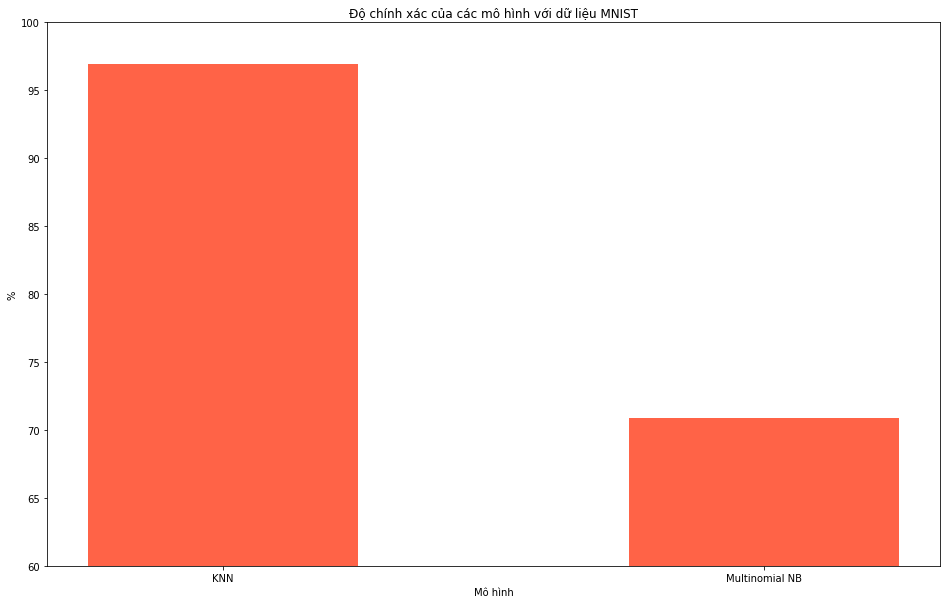

In [425]:
# Về độ chính xác
plt.figure(figsize=(16, 10))
plt.title('Độ chính xác của các mô hình với dữ liệu MNIST')
plt.xlabel('Mô hình')
plt.ylabel('%')
plt.ylim(60, 100)
plt.bar(models, np.array(accuracy_scores) * 100, color='tomato', width=0.5, label='Accuracy')
plt.savefig('image/knn_mnb/mnist_accuracy_comparision.png', facecolor='whitesmoke')
plt.show()

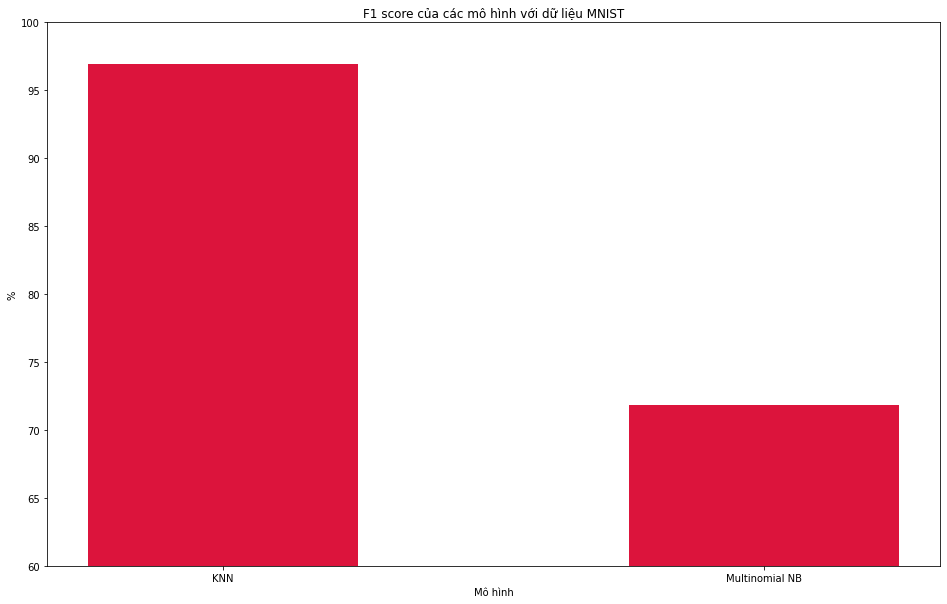

In [426]:
# Về F1 score
plt.figure(figsize=(16, 10))
plt.title('F1 score của các mô hình với dữ liệu MNIST')
plt.xlabel('Mô hình')
plt.ylabel('%')
plt.ylim(60, 100)
plt.bar(models, np.array(f1_scores) * 100, color='crimson', width=0.5, label='F1')
plt.savefig('image/knn_mnb/mnist_f1_comparision.png', facecolor='whitesmoke')
plt.show()

# 3. Vietnamese news

In [4]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.preprocessing import LabelEncoder

## Load, preprocess

In [14]:
# Đường dẫn
train_x_path = 'data/vnnews/train_x.sav'
train_y_path = 'data/vnnews/train_y.sav'
test_x_path = 'data/vnnews/test_x.sav'
test_y_path = 'data/vnnews/test_y.sav'

# Load dữ liệu
x_train = np.array(pickle.load(open(train_x_path, 'rb')))
y_train = np.array(pickle.load(open(train_y_path, 'rb')))
x_test = np.array(pickle.load(open(test_x_path, 'rb')))
y_test = np.array(pickle.load(open(test_y_path, 'rb')))

In [15]:
feature_extractor = Pipeline([
    # Chuyển tập dữ liệu sang dạng vector count dựa trên một vocab chung (BoW), loại bỏ những word có tần suất xuất hiện > 0.8
    ('vectorize', CountVectorizer(max_df=0.8, encoding='utf-16')),
    
    # Áp dụng TF-IDF để trích chọn đặc trưng (extract feature)
    ('feature extracter', TfidfTransformer())
])

train_features = feature_extractor.fit_transform(x_train, y_train)
test_features = feature_extractor.transform(x_test)
print('Kích thước vector input: ', train_features.shape)
print('Kích thước vector test', test_features.shape)

Kích thước vector input:  (14375, 79170)
Kích thước vector test (12076, 79170)


In [16]:
X_train = train_features.astype('float32').toarray()
X_test = test_features.astype('float32').toarray()

In [17]:
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.fit_transform(y_test)

## Train, Evaluate

In [19]:
# Save train time each model
train_times = []
# save scores each model
accuracy_scores = []
f1_scores = []

In [21]:
knn = KNN()

start = time.time()
knn.fit(X_train, y_train, k=7)
y_pred = knn.predict(X_test)

acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='macro')
accuracy_scores.append(acc)
f1_scores.append(f1)

tmp = time.time() - start
train_times.append(tmp)

print('KNN:')
print('Huấn luyện và đánh giá xong sau {:.2f}s'.format(tmp))
print('Accuracy score: {:.3f} %'.format(acc * 100))
print('F1 score:       {:.3f} %'.format(f1 * 100))

KNN:
Huấn luyện và đánh giá xong sau 175.63s
Accuracy score: 80.648 %
F1 score:       76.136 %


In [22]:
mnb = MNB()

start = time.time()
mnb.fit(X_train, y_train, 0.5)
y_pred = mnb.predict(X_test)

acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='macro')
accuracy_scores.append(acc)
f1_scores.append(f1)

tmp = time.time() - start
train_times.append(tmp)

print('MNB:')
print('Huấn luyệnvvà đánh giá xong sau {:.2f}s'.format(tmp))
print('Accuracy score: {:.3f} %'.format(acc * 100))
print('F1 score:       {:.3f} %'.format(f1 * 100))

MNB:
Huấn luyệnvvà đánh giá xong sau 269.65s
Accuracy score: 74.536 %
F1 score:       57.519 %


## Visualize

In [23]:
models = np.array(['KNN', 'Multinomial NB'])

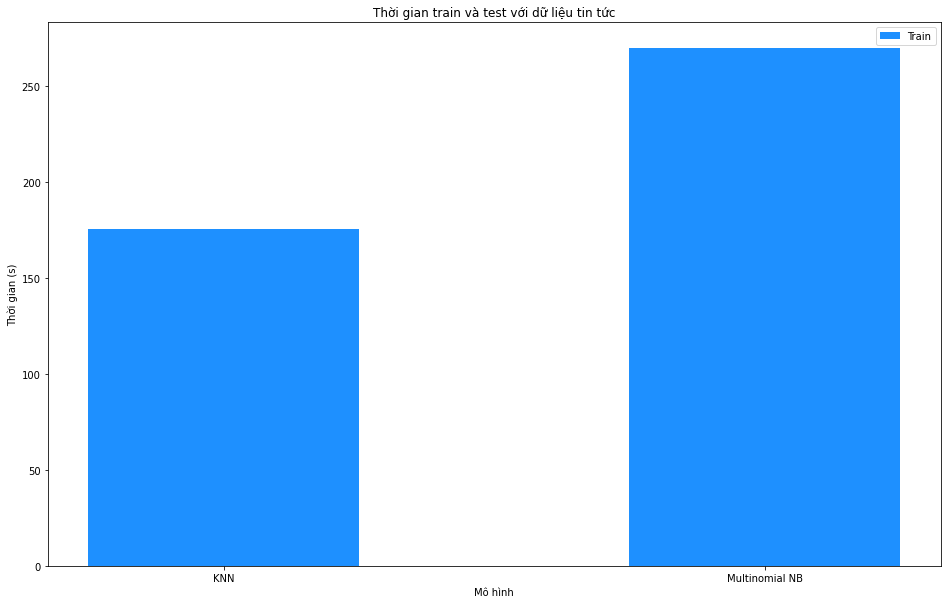

In [24]:
# Về thời gian
plt.figure(figsize=(16, 10))
plt.title('Thời gian train và test với dữ liệu tin tức')
plt.xlabel('Mô hình')
plt.ylabel('Thời gian (s)')
plt.bar(models, np.array(train_times), color='dodgerblue', width=0.5, label='Train')
plt.legend(loc='best')
plt.savefig('image/knn_mnb/vnnews_time_comparision.png', facecolor='whitesmoke')
plt.show()

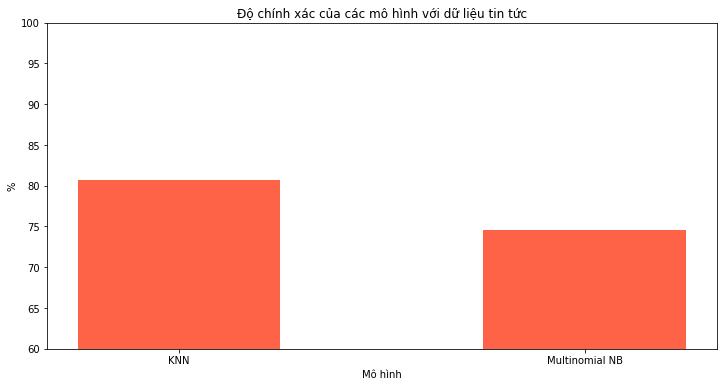

In [25]:
# Về độ chính xác
plt.figure(figsize=(12, 6))
plt.title('Độ chính xác của các mô hình với dữ liệu tin tức')
plt.xlabel('Mô hình')
plt.ylabel('%')
plt.ylim(60, 100)
plt.bar(models, np.array(accuracy_scores) * 100, color='tomato', width=0.5, label='Accuracy')
plt.savefig('image/knn_mnb/vnnews_accuracy_comparision.png', facecolor='whitesmoke')
plt.show()

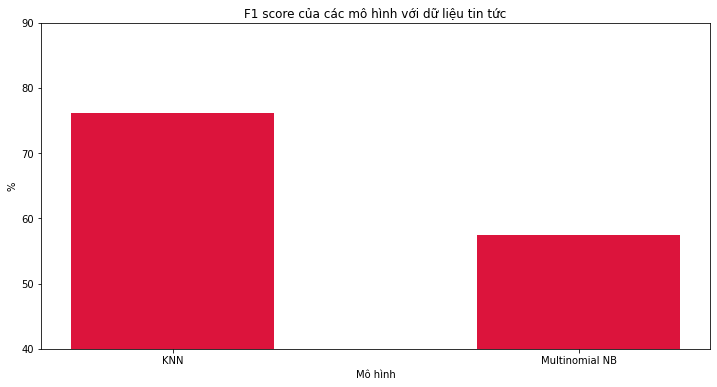

In [26]:
# Về F1 score
plt.figure(figsize=(12, 6))
plt.title('F1 score của các mô hình với dữ liệu tin tức')
plt.xlabel('Mô hình')
plt.ylabel('%')
plt.ylim(40, 90)
plt.bar(models, np.array(f1_scores) * 100, color='crimson', width=0.5, label='F1')
plt.savefig('image/knn_mnb/vnnews_f1_comparision.png', facecolor='whitesmoke')
plt.show()

# 4. Flower

In [137]:
# Đường dẫn
features_path = 'data/flower/flower_features.sav'
labels_path = 'data/flower/flower_labels.sav'

# Load dữ liệu
features = np.array(pickle.load(open(features_path, 'rb')))
labels = np.array(pickle.load(open(labels_path, 'rb')))

In [138]:
# Chia traing set, test set tỉ lệ 80-20
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

In [139]:
max_values = np.max(X_train)
min_values = np.min(X_train)
a, b = 0, 0.5
X_train = a + (X_train - min_values) * (b-a) / (max_values - min_values)
X_test = a + (X_test - min_values) * (b-a) / (max_values - min_values)

## Train, Evaluate

In [140]:
# Save train time each model
train_times = []
# save scores each model
accuracy_scores = []
f1_scores = []

In [141]:
knn = KNN()

start = time.time()
knn.fit(X_train, y_train, k=7)
y_pred = knn.predict(X_test)

acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='macro')
accuracy_scores.append(acc)
f1_scores.append(f1)

tmp = time.time() - start
train_times.append(tmp)

print('KNN:')
print('Huấn luyện và đánh giá xong sau {:.2f}s'.format(tmp))
print('Accuracy score: {:.3f} %'.format(acc * 100))
print('F1 score:       {:.3f} %'.format(f1 * 100))

KNN:
Huấn luyện và đánh giá xong sau 0.23s
Accuracy score: 54.779 %
F1 score:       56.680 %


In [142]:
mnb = MNB()

start = time.time()
mnb.fit(X_train, y_train, 0.1)
y_pred = mnb.predict(X_test)

acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='macro')
accuracy_scores.append(acc)
f1_scores.append(f1)

tmp = time.time() - start
train_times.append(tmp)

print('MNB:')
print('Huấn luyện và đánh giá xong sau {:.2f}s'.format(tmp))
print('Accuracy score: {:.3f} %'.format(acc * 100))
print('F1 score:       {:.3f} %'.format(f1 * 100))

MNB:
Huấn luyện và đánh giá xong sau 1.60s
Accuracy score: 80.515 %
F1 score:       81.657 %


## Visualize

In [143]:
models = np.array(['KNN', 'Multinomial NB'])

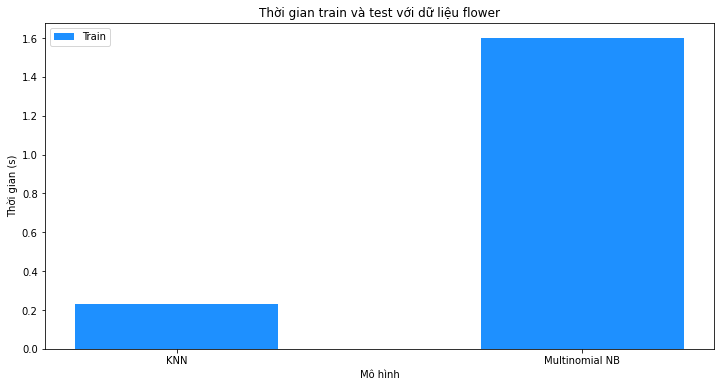

In [144]:
# Về thời gian
plt.figure(figsize=(12, 6))
plt.title('Thời gian train và test với dữ liệu flower')
plt.xlabel('Mô hình')
plt.ylabel('Thời gian (s)')
plt.bar(models, np.array(train_times), color='dodgerblue', width=0.5, label='Train')
plt.legend(loc='best')
plt.savefig('image/knn_mnb/flower_time_comparision.png', facecolor='whitesmoke')
plt.show()

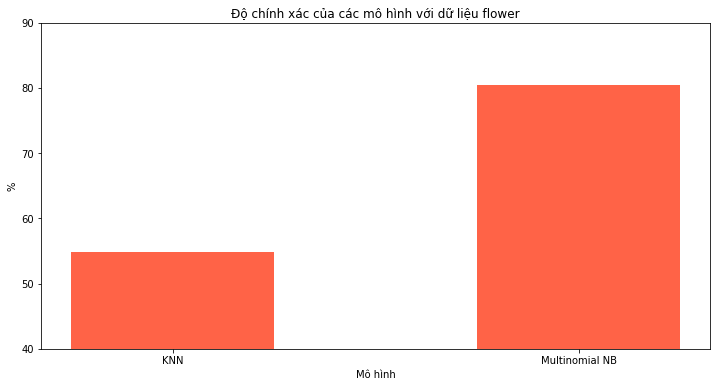

In [145]:
# Về độ chính xác
plt.figure(figsize=(12, 6))
plt.title('Độ chính xác của các mô hình với dữ liệu flower')
plt.xlabel('Mô hình')
plt.ylabel('%')
plt.ylim(40, 90)
plt.bar(models, np.array(accuracy_scores) * 100, color='tomato', width=0.5, label='Accuracy')
plt.savefig('image/knn_mnb/flower_accuracy_comparision.png', facecolor='whitesmoke')
plt.show()

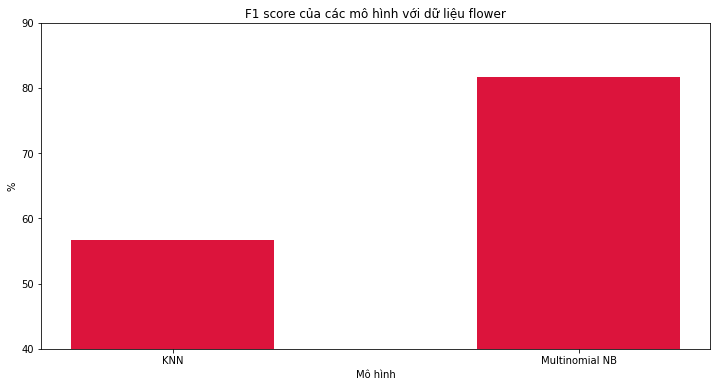

In [146]:
# Về F1 score
plt.figure(figsize=(12, 6))
plt.title('F1 score của các mô hình với dữ liệu flower')
plt.xlabel('Mô hình')
plt.ylabel('%')
plt.ylim(40, 90)
plt.bar(models, np.array(f1_scores) * 100, color='crimson', width=0.5, label='F1')
plt.savefig('image/knn_mnb/flower_f1_comparision.png', facecolor='whitesmoke')
plt.show()

# 5. CIFAR10

# other

In [11]:
import numpy as np
from sklearn import neighbors, datasets
from sklearn.model_selection import train_test_split # for splitting data
from sklearn.metrics import accuracy_score # for evaluating results
iris = datasets.load_iris()
iris_X = iris.data
iris_y = iris.target


In [72]:
X_train, X_test, y_train, y_test = train_test_split(
    iris_X, iris_y, test_size=100)


In [63]:
# train data
d1 = [2, 1, 1, 0, 0, 0, 0, 0, 0]
d2 = [1, 1, 0, 1, 1, 0, 0, 0, 0]
d3 = [0, 1, 0, 0, 1, 1, 0, 0, 0]
d4 = [0, 1, 0, 0, 0, 0, 1, 1, 1]
X_train = np.array([d1, d2, d3, d4])
y_train = np.array([0, 0, 0, 1]) # 0 - B, 1 - N
# test data
d5 = np.array([[2, 0, 0, 1, 0, 0, 0, 1, 0]])
d6 = np.array([[0, 1, 0, 0, 0, 0, 0, 1, 1]])
y_test = np.array([0, 1])
X_test = np.concatenate((d5, d6), axis=0)

In [73]:
mnb = MNB()
mnb.fit(X_train, y_train, 1)
y_pred = mnb.predict(X_test)
print(accuracy_score(y_pred, y_test) * 100)
# print(y_pred)

64.0
